# Regression models 

This script introduces the investigated regression models to map the feature data to CO2 emissions.

Models:
    - Linear Regression with PCA
    - Neural Network
    - PLSR
    - LASSO
    - Ridge
    
At each training section (for each individual sector and for all sectors together) it can be chosen if training and testing plots should be shown (verbose variable in RunModels) and if a Pearson Correlation heat map should be shown.

The regression is done for different input and output parameters. It is divided in the three sectors economy, mobility, and energy and household. Also the regression of all features to the total amount of CO2 emissions is tested.

There are different plots that compare the models within the sections.

## Imports

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import sklearn
import json
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import KFold


plt.rcParams.update({'font.size':16})


Using TensorFlow backend.


# Read database

In [2]:
# Import whole database
with open('feature_database.json') as json_database:
    database = json.load(json_database)

## Read feature data of sectors from database

### Economy

In [3]:
# Concat data from sector economy
X_eco_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'economy':
        new_data = pd.read_json(database[i]['data'])
        if X_eco_raw is None:
            X_eco_raw = new_data
        else:
            X_eco_raw = pd.concat([X_eco_raw, new_data], axis=1, join="inner")

#convert index in datetime format
X_eco_raw['date'] = X_eco_raw.index
X_eco_raw.date = pd.to_datetime(X_eco_raw.date).dt.to_period('m')
X_eco_raw.index = X_eco_raw.date
X_eco_raw = X_eco_raw.drop('date', axis=1)
#X_eco_raw.head()

### Mobility

In [4]:
# Concat data from sector mobility
X_mob_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'mobility':
        new_data = pd.read_json(database[i]['data'])
        if X_mob_raw is None:
            X_mob_raw = new_data
        else:
            X_mob_raw = pd.concat([X_mob_raw, new_data], axis=1, join="inner")
            
#convert index in datetime format
X_mob_raw['date'] = X_mob_raw.index
X_mob_raw.date = pd.to_datetime(X_mob_raw.date).dt.to_period('m')
X_mob_raw.index = X_mob_raw.date
X_mob_raw = X_mob_raw.drop('date', axis=1)
#X_mob_raw.head()

## Energy and households

In [5]:
# Concat data from sector engergy and households
X_eh_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'energy_households':
        new_data = pd.read_json(database[i]['data'])
        if X_eh_raw is None:
            X_eh_raw = new_data
        else:
            X_eh_raw = pd.concat([X_eh_raw, new_data], axis=1, join="inner")

#convert index in datetime format            
X_eh_raw['date'] = X_eh_raw.index
X_eh_raw.date = pd.to_datetime(X_eh_raw.date).dt.to_period('m')
X_eh_raw.index = X_eh_raw.date
X_eh_raw = X_eh_raw.drop('date', axis=1)
#X_eh_raw.head()

## Read CO2 emission data from database

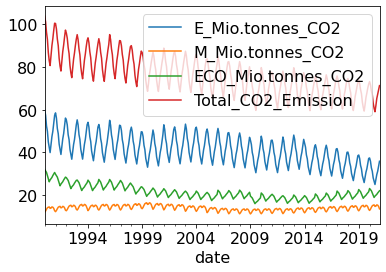

In [6]:
# Concat data from target values
Y_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'target_values':
        new_data = pd.read_json(database[i]['data'])
        if Y_raw is None:
            Y_raw = new_data
        else:
            Y_raw = pd.concat([Y_raw, new_data], axis=1, join="inner")

#convert index in datetime format
Y_raw['date'] = Y_raw.index
Y_raw.date = pd.to_datetime(Y_raw.date).dt.to_period('m')
Y_raw.index = Y_raw.date
Y_raw = Y_raw.drop('date', axis=1)

# plot CO2 emissions
Y_raw.plot()

# Correlation function
Function to generate a person correlation heatmap and visualize the correlation of the features to each other and to the CO2 emissions.
Depending on the number of features this map can have a very bad overview.

In [7]:
def PlotPearsonCorrMap(X,y, title='Pearson correlation'):
    df = pd.concat([y, X], axis=1)
    plt.figure(figsize=(24,20))
    cor = df.corr(method='pearson')
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.title(title)
    plt.show()

# Model Functions
Functions of the models are shown here. 

Return of each function:
    - best working estimator based on the optimization parameters
    - scaler if needed

## Model 1: Linear Regression

In [8]:
def my_LinearRegression(x, y, x_future, degree, verbose):
    
    # polynomial transformation in order to model a polynomial fit
    poly = PolynomialFeatures(degree=1)
    X_train = poly.fit_transform(x)

    # Scaling
    scaler = StandardScaler()
    #scaler = RobustScaler()
    #scaler = MinMaxScaler()

    # PCA
    pca = PCA()

    # Cross-validation
    #cval = LeaveOneOut() 
    cval = KFold(n_splits=10)

    # Estimator
    estimator = LinearRegression()

    #pipeline with scaler, PCA, and estimator
    pipe = Pipeline(steps=[('scaler',scaler),('pca', pca), ('estimator', estimator)])
    param_grid = {'pca__n_components': range(1,X_train.shape[1]+1)}

    # GridSearch with cross validation
    search = GridSearchCV(pipe, param_grid, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
    search.fit(X_train, y)
    
    
    #best estimator based on GridSearch
    best_estimator = search.best_estimator_
    
    # 
    y_pred_train = best_estimator.predict(X_train)
    
    #mean scores of GridSearchCV 
    best_param = search.best_params_['pca__n_components']
    mean_train_score = search.cv_results_['mean_train_score'][best_param]
    mean_test_score = search.cv_results_['mean_test_score'][best_param]
    
    mean_score = [-mean_train_score, -mean_test_score]
    
    
#plots and output
    if verbose:
        print('################################################################################')
        print('Polynomial Fit/Linear Regression with degree: ', degree)
        print('################################################################################')

        #print number of PCA components with best result
        print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
        print(search.best_params_)

        #plots
        plt.figure()
        plt.errorbar(range(1,X_train.shape[1]+1),-search.cv_results_['mean_test_score'],yerr=search.cv_results_['std_test_score'])
        #plt.plot(range(1,X_train.shape[1]+1),-search.cv_results_['mean_train_score'])
        plt.xticks(range(1,X_train.shape[1]+1))
        plt.xlabel("number of principle components")
        plt.ylabel("CV result score")
        plt.title("Grid search results for PCA components")

        print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y,y_pred_train)))
        print("R2 training fit: %.03f " %r2_score(y,y_pred_train))
        #print("RMSE prediction: %.03f" %np.sqrt(mean_squared_error(y_test,y_pred_test)))
        #print("R2 prediction: %.03f " %r2_score(y_test,y_pred_test))

        # predicted/actual plot for test set
        ax = sns.jointplot(x=y_pred_train,y=y)
        ax.ax_joint.set_xlabel('Prediction')
        ax.ax_joint.set_ylabel('True')

        y_pred_future = best_estimator.predict(poly.transform(x_future))


        plt.figure()
        plt.plot(y_pred_future)
        plt.title('Predictions 2018 - 2020')
        plt.ylabel('Mio. tonnes CO2')
        
        plt.show()
    else:
        plt.close()
        
    return best_estimator, poly, mean_score

## Model 2: Neuronal Network

In [9]:
def my_NeuronalNetwork(x, y, x_future, verbose):
    
    
    
    scaler = MinMaxScaler()
    scaler.fit(x)
    x_scaled = scaler.transform(x)

    #X_train, X_val, Y_train, Y_val = train_test_split(x_scaled, y, test_size=.2)

    
    y = y[y.columns[0]].to_numpy()
    
    #cross validation
    kf = KFold(n_splits=10)
    
    rmse_train = []
    rmse_test = []
    
    for train_index, test_index in kf.split(x_scaled):

    
        X_train, X_test = x_scaled[train_index], x_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        network = models.Sequential()
        network.add(layers.Dense(2, activation='relu', input_shape=(len(X_train[0]),)))
        #network.add(layers.Dense(2, activation='relu'))
        network.add(layers.Dense(1))

        network.compile(optimizer=optimizers.RMSprop(lr=0.01),
                  loss='mean_squared_error',
                  metrics=['mse'])

        history = network.fit(X_train, y_train, batch_size=5, epochs=200, validation_data=(X_test,y_test), verbose=0)

        y_pred_train = network.predict(X_train)
        y_pred_test = network.predict(X_test)
        
        rmse_train.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
        rmse_test.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
    
    #take average of scores of cross validation
    mean_score = [np.mean(rmse_train), np.mean(rmse_test)]
    
#plots and output
    if verbose:
        
        print('################################################################################')
        print('Neural Network Regression')
        print('################################################################################')

        network.summary()
        
        mse = history.history['mse'] #TO DO: take from the history dictionary of the model the training accuracy
        val_mse =  history.history['val_mse'] #TO DO: take from the history dictionary of the model the validation accuracy
        loss =  history.history['loss'] #TO DO: take from the history dictionary of the model the training loss
        val_loss =  history.history['val_loss'] #TO DO: take from the history dictionary of the model the validation loss 

        epochs = range(1, len(mse) + 1)


        # Plot the Loss
        plt.plot(loss)
        # "bo" is for "blue dot"
        plt.plot(epochs, loss, 'b', label='Training loss') 
        # b is for "solid blue line"
        plt.plot(epochs,  val_loss, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        y_pred_train = network.predict(x_scaled)
        ax = sns.jointplot(x=y_pred_train,y=y)
        ax.ax_joint.set_xlabel('Prediction')
        ax.ax_joint.set_ylabel('True')

        x_future_scaled = scaler.transform(x_future)
        y_pred_future = network.predict(x_future_scaled)

        plt.figure()
        plt.plot(y_pred_future)
        plt.title('Predictions 2018 - 2020')
        plt.ylabel('Mio. tonnes CO2')

        plt.show()
    else:
        plt.close()
        
    return network, scaler, mean_score

## Model 3: PLSR

In [10]:
def my_PLSR(x, y, x_future, verbose):
    
          
    scaler = StandardScaler()
    cval = KFold(n_splits=10)
    plsr = PLSRegression()
    ct = ColumnTransformer([('scaler', scaler, np.arange(0,8))],remainder='passthrough')

    pipe = Pipeline(steps=[('scaler',ct), ('plsr', plsr)])
    param_grid = {'plsr__n_components': range(1,x.shape[1]+1)}

    search = GridSearchCV(pipe, param_grid, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
    search.fit(x, y)
    
    best_estimator = search.best_estimator_
    y_pred_train = best_estimator.predict(x)
    
    #mean scores of GridSearchCV 
    best_param = search.best_params_['plsr__n_components']
    mean_train_score = search.cv_results_['mean_train_score'][best_param]
    mean_test_score = search.cv_results_['mean_test_score'][best_param]
    
    mean_score = [-mean_train_score, -mean_test_score]
    
#plots and output
    if verbose:
        
        print('################################################################################')
        print('PLSR Regression')
        print('################################################################################')

        print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
        print(search.best_params_)

        plt.figure()
        plt.errorbar(range(1,x.shape[1]+1),-search.cv_results_['mean_test_score'],yerr=search.cv_results_['std_test_score'],label='Test')
        plt.errorbar(range(1,x.shape[1]+1),-search.cv_results_['mean_train_score'],yerr=search.cv_results_['std_train_score'],label='Train')
        plt.legend()
        plt.xticks(range(1,x.shape[1]+1))
        plt.xlabel("number of principle components")
        plt.title("Grid search results for PCA components")

        print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y,y_pred_train)))
        print("R2 training fit: %.03f " %r2_score(y,y_pred_train))

        ax = sns.jointplot(x=y_pred_train,y=y)
        ax.ax_joint.set_xlabel('Prediction')
        ax.ax_joint.set_ylabel('True')

        y_pred_future = best_estimator.predict(x_future)

        plt.figure()
        plt.plot(y_pred_future)
        plt.title('Predictions 2018 - 2020')
        plt.ylabel('Mio. tonnes CO2')
    
        plt.show()
    else:
        plt.close()
        
    return best_estimator, mean_score

## Model 4: LASSO

In [11]:
def my_LASSO(x, y, x_future, alphas, verbose):
    
    
    scaler = StandardScaler()
    scaler.fit(x)
    x_scaled = scaler.transform(x)

    cval = KFold(n_splits=10)
    lsso = Lasso()

    tuned_parameters = [{'alpha': alphas}]

    search = GridSearchCV(lsso, tuned_parameters, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
    search.fit(x_scaled, y)
    
    best_estimator = search.best_estimator_
    y_pred_train = best_estimator.predict(x_scaled)
    
    
    df_results = pd.DataFrame(search.cv_results_)
    
    #mean scores of GridSearchCV 
    
    best_param = search.best_params_['alpha']
    ind = np.argmin(abs(alphas-best_param))
    
    mean_train_score = search.cv_results_['mean_train_score'][ind]
    mean_test_score = search.cv_results_['mean_test_score'][ind]
    
    mean_score = [-mean_train_score, -mean_test_score]
    
  
#plots and output
    if verbose:
        
        print('################################################################################')
        print('LASSO Regression')
        print('################################################################################')

        print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
        print(search.best_params_)

        plt.figure()
        plt.errorbar(alphas,-search.cv_results_['mean_test_score'],yerr=search.cv_results_['std_test_score'],label='Test')
        plt.errorbar(alphas,-search.cv_results_['mean_train_score'],yerr=search.cv_results_['std_train_score'],label='Train')
        plt.legend()
        plt.xticks(alphas)
        plt.xlabel("alpha")
        plt.ylabel("CV result score")
        plt.title("Grid search results for alpha")




        print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y,y_pred_train)))
        print("R2 training fit: %.03f " %r2_score(y,y_pred_train))

        ax = sns.jointplot(x=y_pred_train.reshape(-1,1),y=y)
        ax.ax_joint.set_xlabel('Prediction')
        ax.ax_joint.set_ylabel('True')


        x_future_scaled = scaler.transform(x_future)
        y_pred_future = best_estimator.predict(x_future_scaled).reshape(-1,1)

        plt.figure()
        plt.plot(y_pred_future)
        plt.title('Predictions 2018 - 2020')
        plt.ylabel('Mio. tonnes CO2')
    
        plt.show()
    else:
        plt.close()
        
    return best_estimator, scaler, mean_score

## Model 5: Ridge

In [12]:
def my_Ridge(x, y, x_future, alphas, verbose):
    
    
    scaler = StandardScaler()
    scaler.fit(x)
    x_scaled = scaler.transform(x)

    cval = KFold(n_splits=10)
    rdge = Ridge()


    tuned_parameters = [{'alpha': alphas}]

    search = GridSearchCV(rdge, tuned_parameters, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
    search.fit(x_scaled, y)
    

    best_estimator = search.best_estimator_
    y_pred_train = best_estimator.predict(x_scaled)
    
    #mean scores of GridSearchCV 
    best_param = search.best_params_['alpha']
    ind = np.argmin(abs(alphas-best_param))
    
    mean_train_score = search.cv_results_['mean_train_score'][ind]
    mean_test_score = search.cv_results_['mean_test_score'][ind]
    
    mean_score = [-mean_train_score, -mean_test_score]

#plots and output
    if verbose:
        
        print('################################################################################')
        print('Ridge Regression')
        print('################################################################################')

        print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
        print(search.best_params_)

        plt.figure()
        plt.errorbar(alphas,-search.cv_results_['mean_test_score'],yerr=search.cv_results_['std_test_score'],label='Test')
        plt.errorbar(alphas,-search.cv_results_['mean_train_score'],yerr=search.cv_results_['std_train_score'],label='Train')
        plt.legend()
        plt.xticks(alphas)
        plt.xlabel("alpha")
        plt.ylabel("CV result score")
        plt.title("Grid search results for alpha")
        
        print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y,y_pred_train)))
        print("R2 training fit: %.03f " %r2_score(y,y_pred_train))

        ax = sns.jointplot(x=y_pred_train.reshape(-1,1),y=y)
        ax.ax_joint.set_xlabel('Prediction')
        ax.ax_joint.set_ylabel('True')

        x_future_scaled = scaler.transform(x_future)
        y_pred_future = best_estimator.predict(x_future_scaled).reshape(-1,1)

        plt.figure()
        plt.plot(y_pred_future)
        plt.title('Predictions 2018 - 2020')
        plt.ylabel('Mio. tonnes CO2')
    
        plt.show()
    else:
        plt.close()
        
    return best_estimator, scaler, mean_score

## Function to run all models based on input features X and ground truth y

Runs five above introduces models.
Training time period and testing time period can be adjusted.

Return: 3 dataframes:
    - df_result: r2 and rmse of each model 
    - df_result_arr: estimated CO2 emission of each model for the test period
    - df_result_arr_train: estimated CO2 emission of each model for the train period

In [13]:
def RunModels(X, y, verbose=False):
    
#prepare features and ground truth

    #train data
    X_train = X[(X.index.year <= 2019)]
    y_train = y[(y.index.year <= 2019)]
    y_train = y_train[(y_train.index >= X.index.min())]
    
    #test data
    #overlap with train time span because the test set is not really a test set 
    #but represents the time during Corona and the two years before
    X_test = X[(X.index.year > 2017)]
    X_test = X_test[(X_test.index.year <= 2020)]

    y_test = y[(y.index.year > 2017)]
    y_test = y_test[(y_test.index <= X_test.index.max())]
    
#dataframe for numeric results
    arr_zeros = np.zeros((5,))
    df_result = pd.DataFrame({'r2_train':arr_zeros, 'rmse_train':arr_zeros}, index=['LR', 'NN', 'PLSR', 'LASSO', 'Ridge'])
    
    df_result_mean_score = pd.DataFrame({'mse_mean_train':arr_zeros, 'mse_mean_test':arr_zeros}, index=['LR', 'NN', 'PLSR', 'LASSO', 'Ridge'])
    
    arr_zeros = np.zeros((y_test.shape[0],))
    df_result_arr = pd.DataFrame({'LR':arr_zeros, 'NN':arr_zeros, 'PLSR':arr_zeros, 'LASSO':arr_zeros, 'Ridge':arr_zeros, 'OekoInstitute': np.array(y_test.values).flatten()}, index=y_test.index)

    arr_zeros = np.zeros((y_train.shape[0],))
    df_result_arr_train = pd.DataFrame({'LR':arr_zeros, 'NN':arr_zeros, 'PLSR':arr_zeros, 'LASSO':arr_zeros, 'Ridge':arr_zeros, 'OekoInstitute': np.array(y_train.values).flatten()}, index=y_train.index)

    
#Models
    ######
    #Linear/Non-Linear Regression 
    LR, LR_POLY, mean_score_LR = my_LinearRegression(X_train,y_train,X_test,1, verbose)
    
    #estimate CO2 emissions based on input and save it in dataframe
    y_pred_train_LR = LR.predict(LR_POLY.transform(X_train))
    
    
    y_pred_test_LR = LR.predict(LR_POLY.transform(X_test))

    df_result['r2_train']['LR'] = r2_score(y_train,y_pred_train_LR)
    df_result['rmse_train']['LR'] = np.sqrt(mean_squared_error(y_train,y_pred_train_LR))
    df_result_mean_score['mse_mean_train']['LR'] = mean_score_LR[0]
    df_result_mean_score['mse_mean_test']['LR'] = mean_score_LR[1]
    
    df_result_arr['LR'] = y_pred_test_LR
    df_result_arr_train['LR'] = y_pred_train_LR
    
    
    ######
    #NN
    NN, NN_SCALER, mean_score_NN = my_NeuronalNetwork(X_train,y_train,X_test, verbose)

    #estimate CO2 emissions based on input and save it in dataframe
    X_train_scaled = NN_SCALER.transform(X_train)
    X_test_scaled = NN_SCALER.transform(X_test)

    y_pred_train_NN = NN.predict(X_train_scaled)
    y_pred_test_NN = NN.predict(X_test_scaled)

    df_result['r2_train']['NN'] = r2_score(y_train,y_pred_train_NN)
    df_result['rmse_train']['NN'] = np.sqrt(mean_squared_error(y_train,y_pred_train_NN))
    
    df_result_arr['NN'] = y_pred_test_NN
    df_result_arr_train['NN'] = y_pred_train_NN
    
    df_result_mean_score['mse_mean_train']['NN'] = mean_score_NN[0]
    df_result_mean_score['mse_mean_test']['NN'] = mean_score_NN[1]
    
    ######
    #PLSR
    PLSR, mean_score_PLSR = my_PLSR(X_train, y_train, X_test, verbose)
    
    #estimate CO2 emissions based on input and save it in dataframe
    y_pred_train_PLSR = PLSR.predict(X_train)
    y_pred_test_PLSR = PLSR.predict(X_test)

    df_result['r2_train']['PLSR'] = r2_score(y_train,y_pred_train_PLSR)
    df_result['rmse_train']['PLSR'] = np.sqrt(mean_squared_error(y_train,y_pred_train_PLSR))
    df_result_mean_score['mse_mean_train']['PLSR'] = mean_score_PLSR[0]
    df_result_mean_score['mse_mean_test']['PLSR'] = mean_score_PLSR[1]
    
    df_result_arr['PLSR'] = y_pred_test_PLSR
    df_result_arr_train['PLSR'] = y_pred_train_PLSR
    
    ######
    #LASSO
    alphas = np.linspace(0,0.2,50)

    LASSO, LASSO_SCALER, mean_score_Lasso = my_LASSO(X_train, y_train, X_test, alphas, verbose)
    
    #estimate CO2 emissions based on input and save it in dataframe
    X_train_scaled = LASSO_SCALER.transform(X_train)
    X_test_scaled = LASSO_SCALER.transform(X_test)

    y_pred_train_LASSO = LASSO.predict(X_train_scaled)
    y_pred_test_LASSO = LASSO.predict(X_test_scaled)

    df_result['r2_train']['LASSO'] = r2_score(y_train,y_pred_train_LASSO)
    df_result['rmse_train']['LASSO'] = np.sqrt(mean_squared_error(y_train,y_pred_train_LASSO))
    df_result_mean_score['mse_mean_train']['LASSO'] = mean_score_Lasso[0]
    df_result_mean_score['mse_mean_test']['LASSO'] = mean_score_Lasso[1]
    
    df_result_arr['LASSO'] = y_pred_test_LASSO
    df_result_arr_train['LASSO'] = y_pred_train_LASSO
    
    ######
    #Ridge
    alphas = np.linspace(5,8,50)

    RIDGE, Ridge_SCALER, mean_score_Ridge = my_Ridge(X_train, y_train, X_test, alphas, verbose)

    #estimate CO2 emissions based on input and save it in dataframe
    X_train_scaled = Ridge_SCALER.transform(X_train)
    X_test_scaled = Ridge_SCALER.transform(X_test)

    y_pred_train_Ridge = RIDGE.predict(X_train_scaled)
    y_pred_test_Ridge = RIDGE.predict(X_test_scaled)

    df_result['r2_train']['Ridge'] = r2_score(y_train,y_pred_train_Ridge)
    df_result['rmse_train']['Ridge'] = np.sqrt(mean_squared_error(y_train,y_pred_train_Ridge))
    df_result_mean_score['mse_mean_train']['Ridge'] = mean_score_Ridge[0]
    df_result_mean_score['mse_mean_test']['Ridge'] = mean_score_Ridge[1]
    
    df_result_arr['Ridge'] = y_pred_test_Ridge
    df_result_arr_train['Ridge'] = y_pred_train_Ridge

    print('Training done!')
    
    return df_result, df_result_arr, df_result_arr_train, df_result_mean_score

# Train the models
X: feature matrix \
y: CO2 Emissions

## Economy

In [14]:
X = X_eco_raw #.loc['2011-01':'2020-03']
y = Y_raw[['ECO_Mio.tonnes_CO2']]

In [15]:
# Plot pearson correlation heat map
#PlotPearsonCorrMap(X,y, title='Pearson correlation sector Economy')

In [16]:
# train the models
df_result_ECO, df_result_arr_ECO, df_result_arr_train_ECO, df_result_mean_score_ECO = RunModels(X, y, verbose=False)
df_result_mean_score_ECO

Training done!


,mse_mean_train,mse_mean_test
LR,0.760467,1.320968
NN,1.401343,1.401343
PLSR,0.737625,1.284007
LASSO,0.730821,1.209701
Ridge,0.775661,1.255688


,r2_train,rmse_train
LR,0.612866,0.916556
NN,0.540289,0.998782
PLSR,0.639155,0.884889
LASSO,0.656290,0.863623
Ridge,0.637041,0.887477


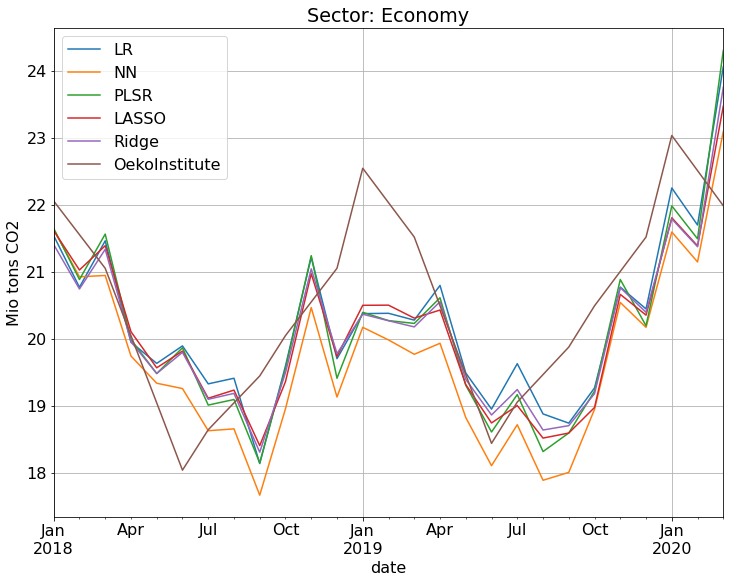

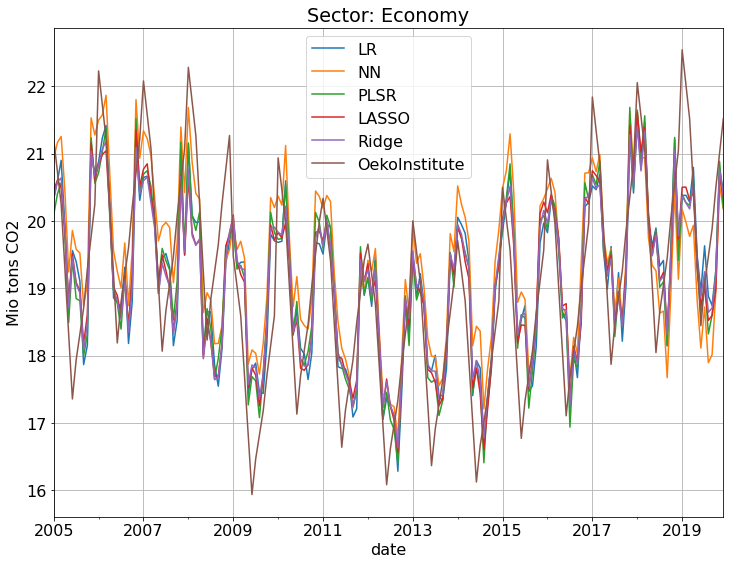

In [17]:

#Plot estimated CO2 emissions of the time span 2018 until 2020
df_result_arr_ECO.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Economy')

#Plot estimated CO2 emissions until 12/2019
df_result_arr_train_ECO.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Economy')

#show the r2 and rmse of the training set
df_result_ECO

## Mobility

In [18]:
X = X_mob_raw
y = Y_raw[['M_Mio.tonnes_CO2']]

In [19]:
# Plot pearson correlation heat map
#PlotPearsonCorrMap(X,y, title='Pearson correlation sector Mobility')

In [20]:
df_result_M, df_result_arr_M, df_result_arr_train_M, df_result_mean_score_M = RunModels(X, y, verbose=False)

Training done!


In [21]:
df_result_mean_score_M

,mse_mean_train,mse_mean_test
LR,0.180744,0.205173
NN,0.771404,0.771404
PLSR,0.119372,0.214985
LASSO,0.140890,0.197487
Ridge,0.132118,0.193034


,r2_train,rmse_train
LR,0.789189,0.424982
NN,-0.014561,0.932314
PLSR,0.855753,0.351542
LASSO,0.833264,0.377953
Ridge,0.844260,0.365278


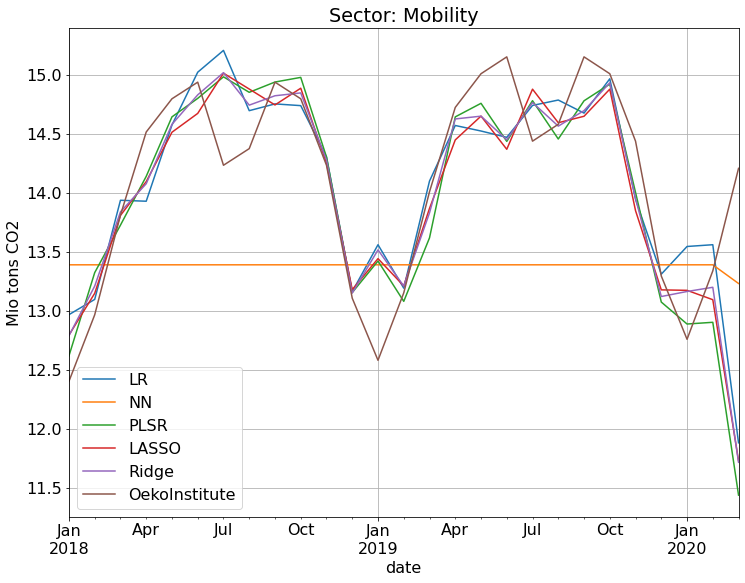

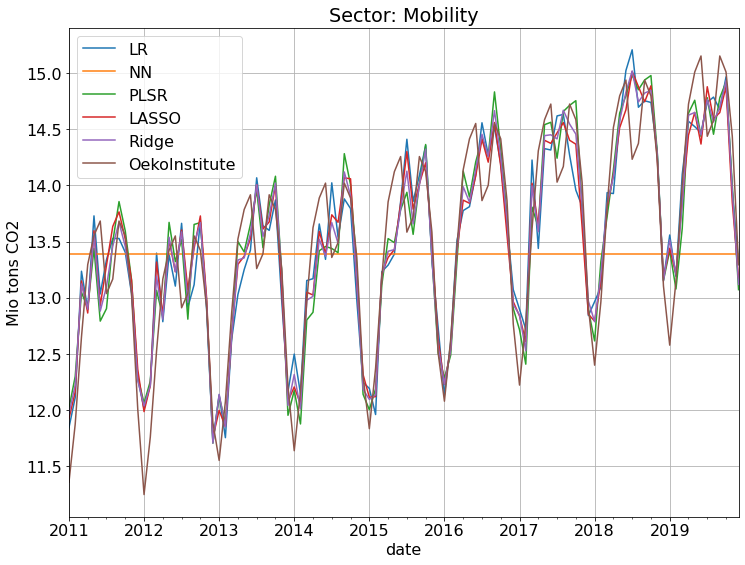

In [22]:
#Plot estimated CO2 emissions of the time span 2018 until 2020
df_result_arr_M.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Mobility')

#Plot estimated CO2 emissions until 12/2019
df_result_arr_train_M.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Mobility')

#show the r2 and rmse of the training set
df_result_M

## Energy and Household

In [23]:
X = X_eh_raw #.loc[:'2020-03']
y = Y_raw[['E_Mio.tonnes_CO2']]

In [24]:
# Plot pearson correlation heat map
#PlotPearsonCorrMap(X,y, title='Pearson correlation sector Energy and Household')

In [25]:
df_result_EH, df_result_arr_EH, df_result_arr_train_EH, df_result_mean_score_EH = RunModels(X, y, verbose=False)
df_result_mean_score_EH

Training done!


,mse_mean_train,mse_mean_test
LR,2.491168,3.818930
NN,2.901156,2.901156
PLSR,2.491229,3.820517
LASSO,2.531855,3.532195
Ridge,2.548499,3.767563


,r2_train,rmse_train
LR,0.908086,1.594885
NN,0.888019,1.760398
PLSR,0.908068,1.595040
LASSO,0.906909,1.605065
Ridge,0.906337,1.609992


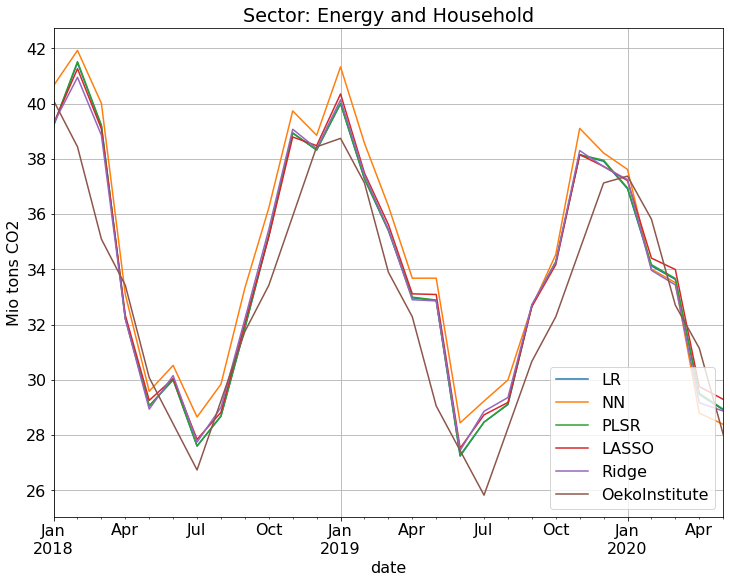

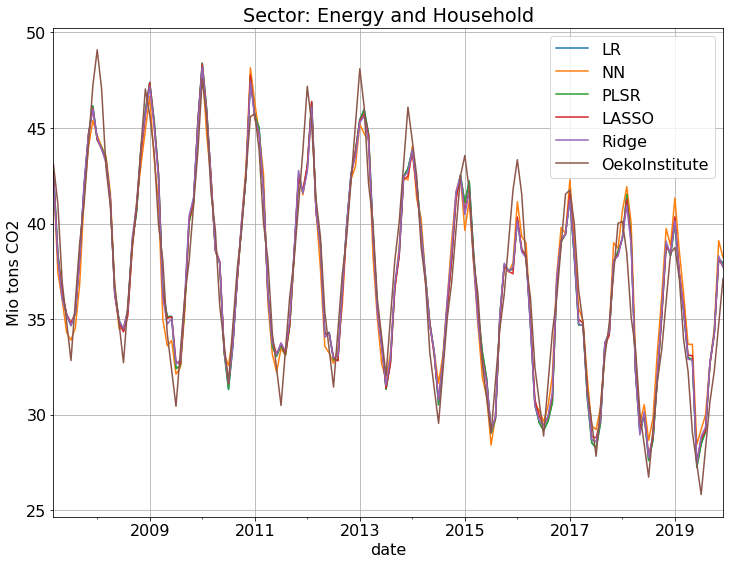

In [26]:
#Plot estimated CO2 emissions of the time span 2018 until 2020
df_result_arr_EH.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Energy and Household')

#Plot estimated CO2 emissions until 12/2019
df_result_arr_train_EH.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Energy and Household')

#show the r2 and rmse of the training set
df_result_EH

# All sectors

In [27]:
X = pd.concat([X_eh_raw, X_mob_raw], axis=1)
y = Y_raw[['Total_CO2_Emission']]
df = pd.concat([X,y], axis=1).dropna(axis=0)
y = df[['Total_CO2_Emission']]
X = df.drop('Total_CO2_Emission', axis=1)

In [28]:
# Plot pearson correlation heat map
#PlotPearsonCorrMap(X,y, title='Pearson correlation all sectors')

In [29]:
df_result_all,df_result_arr_all,df_result_arr_train_all, df_result_mean_score_all = RunModels(X, y, verbose=False)
df_result_mean_score_all

Training done!


,mse_mean_train,mse_mean_test
LR,1.575937,2.641318
NN,6.606284,6.606284
PLSR,1.639895,2.518513
LASSO,1.615828,2.395521
Ridge,1.654740,2.490773


,r2_train,rmse_train
LR,0.935713,1.303593
NN,0.693441,2.846665
PLSR,0.933674,1.324097
LASSO,0.937507,1.285269
Ridge,0.936496,1.295629


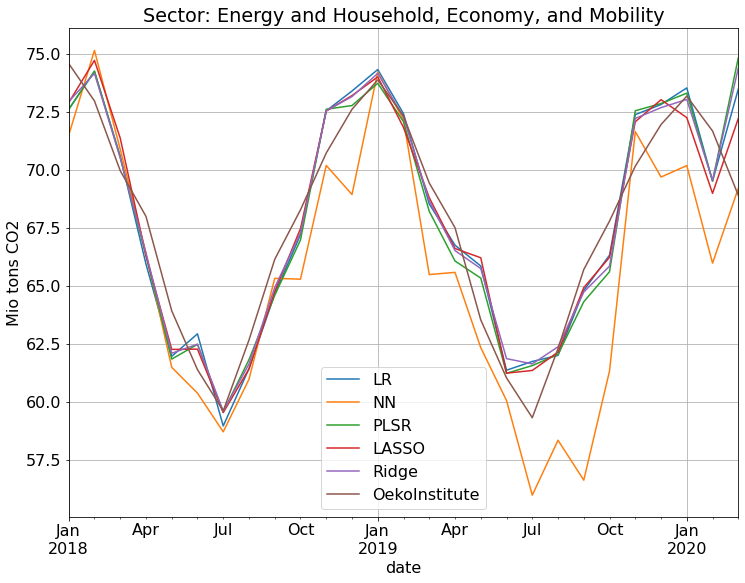

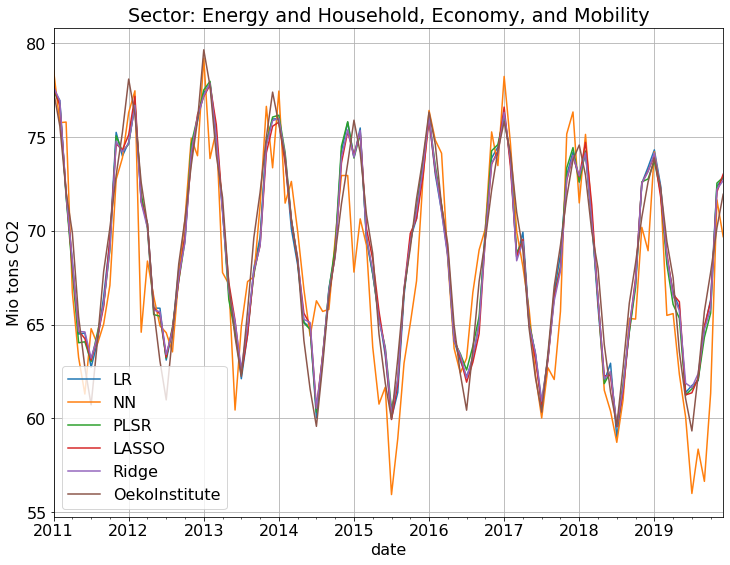

In [30]:
#Plot estimated CO2 emissions of the time span 2018 until 2020
df_result_arr_all.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Energy and Household, Economy, and Mobility')

#Plot estimated CO2 emissions until 12/2019
df_result_arr_train_all.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Energy and Household, Economy, and Mobility')

#show the r2 and rmse of the training set
df_result_all

# Report figures

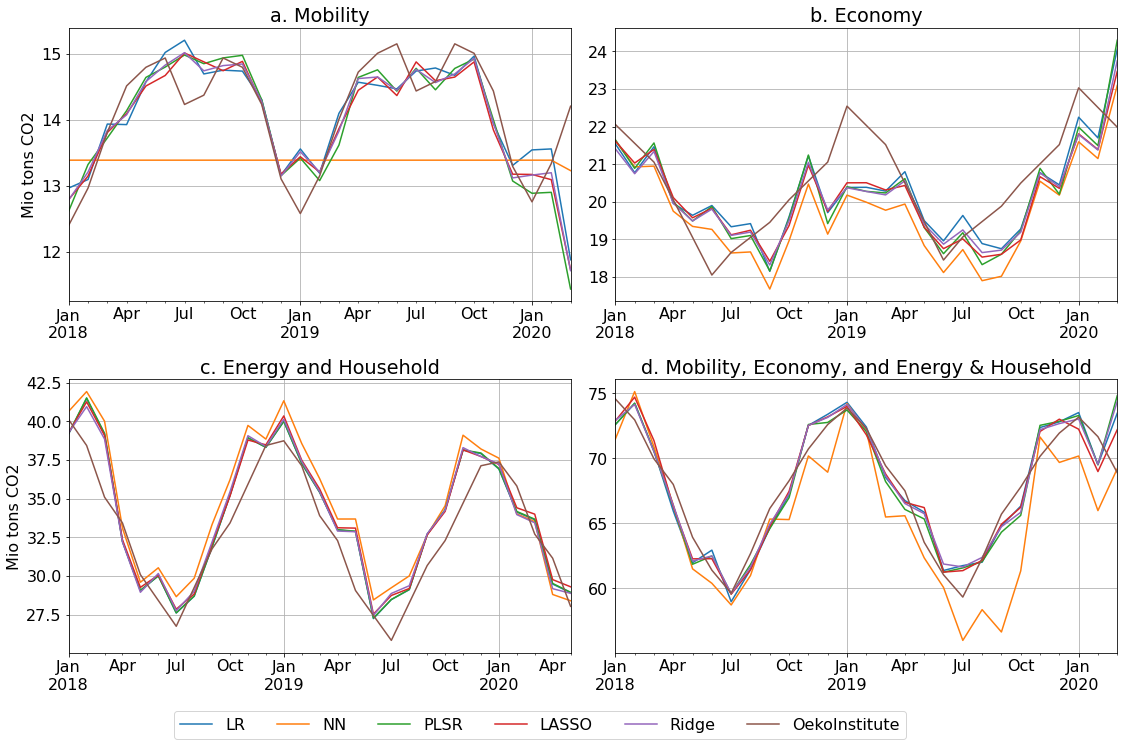

In [31]:
f,ax = plt.subplots(2,2, figsize=(16,10))
#f.figsize=(12,9)

df_result_arr_M.plot(subplots=False, ax=ax[0,0], legend=False, sharex=False)
ax[0,0].set_title('a. Mobility')
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Mio tons CO2')
ax[0,0].grid()

df_result_arr_ECO.plot(subplots=False, ax=ax[0,1], legend=False)
ax[0,1].set_title('b. Economy')
ax[0,1].set_xlabel('')
#ax[0,1].set_ylabel('Mio tons CO2')
ax[0,1].grid()

df_result_arr_EH.plot(subplots=False, ax=ax[1,0], legend=False)
ax[1,0].set_title('c. Energy and Household')
ax[1,0].set_xlabel('')
ax[1,0].set_ylabel('Mio tons CO2')
ax[1,0].grid()


df_result_arr_all.plot(subplots=False, ax=ax[1,1], legend=False, sharex=False)
ax[1,1].set_title('d. Mobility, Economy, and Energy & Household')
ax[1,1].set_xlabel('')
#ax[1,1].set_ylabel('Mio tons CO2')
ax[1,1].grid()
f.tight_layout()
lgd = ax[1,1].legend(loc='lower center', bbox_to_anchor=(-0.15, -0.32), ncol=len(df.columns), borderaxespad=0.1) 


plt.savefig('ResultMapping_SharedPlot.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

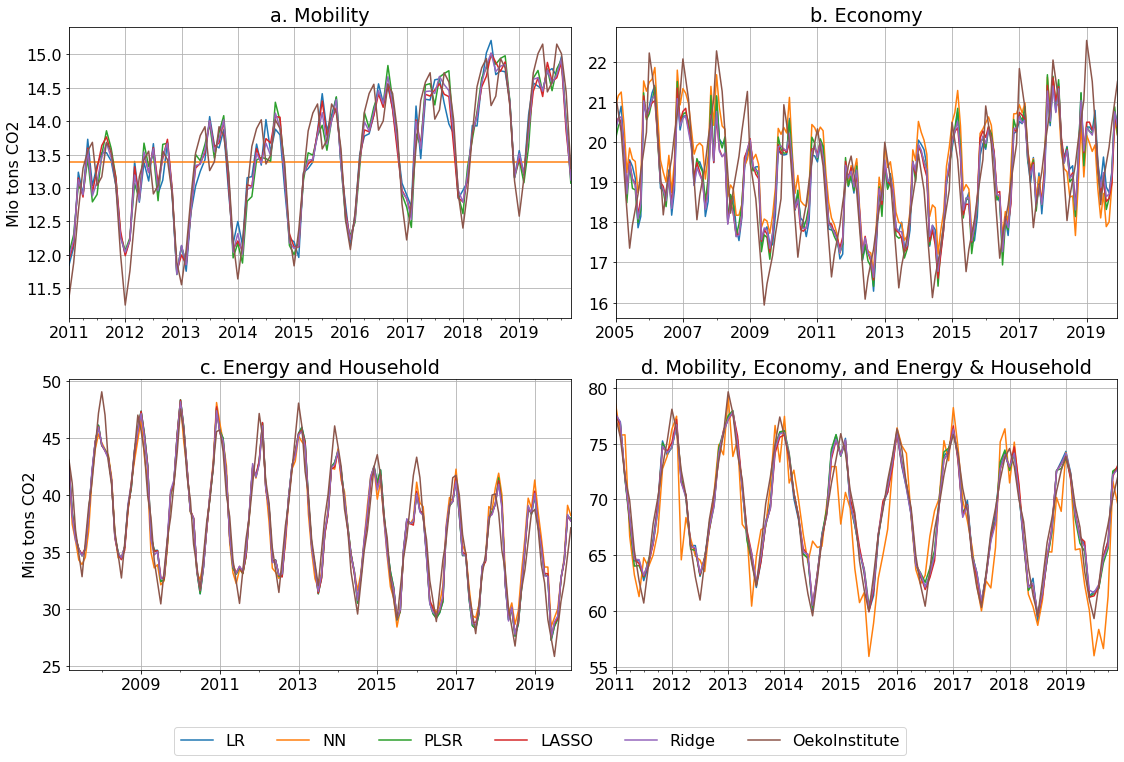

In [32]:
f,ax = plt.subplots(2,2, figsize=(16,10))
#f.figsize=(12,9)

df_result_arr_train_M.plot(subplots=False, ax=ax[0,0], legend=False, sharex=False)
ax[0,0].set_title('a. Mobility')
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Mio tons CO2')
ax[0,0].grid()

df_result_arr_train_ECO.plot(subplots=False, ax=ax[0,1], legend=False)
ax[0,1].set_title('b. Economy')
ax[0,1].set_xlabel('')
#ax[0,1].set_ylabel('Mio tons CO2')
ax[0,1].grid()

df_result_arr_train_EH.plot(subplots=False, ax=ax[1,0], legend=False)
ax[1,0].set_title('c. Energy and Household')
ax[1,0].set_xlabel('')
ax[1,0].set_ylabel('Mio tons CO2')
ax[1,0].grid()


df_result_arr_train_all.plot(subplots=False, ax=ax[1,1], legend=False, sharex=False)
ax[1,1].set_title('d. Mobility, Economy, and Energy & Household')
ax[1,1].set_xlabel('')
#ax[1,1].set_ylabel('Mio tons CO2')
ax[1,1].grid()
f.tight_layout()
ax[1,1].legend(loc='lower center', bbox_to_anchor=(-0.15, -0.32), ncol=len(df.columns)) 

plt.savefig('ResultMapping_train_SharedPlot.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

# Metrics of Cross validation: RMSE

In [33]:
df_result_mean_score_ECO.pow(1/2).round(2)

,mse_mean_train,mse_mean_test
LR,0.87,1.15
NN,1.18,1.18
PLSR,0.86,1.13
LASSO,0.85,1.10
Ridge,0.88,1.12


In [34]:
df_result_mean_score_M.pow(1/2).round(2)

,mse_mean_train,mse_mean_test
LR,0.43,0.45
NN,0.88,0.88
PLSR,0.35,0.46
LASSO,0.38,0.44
Ridge,0.36,0.44


In [35]:
df_result_mean_score_EH.pow(1/2).round(2)

,mse_mean_train,mse_mean_test
LR,1.58,1.95
NN,1.70,1.70
PLSR,1.58,1.95
LASSO,1.59,1.88
Ridge,1.60,1.94


In [36]:
df_result_mean_score_all.pow(1/2).round(2)

,mse_mean_train,mse_mean_test
LR,1.26,1.63
NN,2.57,2.57
PLSR,1.28,1.59
LASSO,1.27,1.55
Ridge,1.29,1.58
